In [152]:
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import json
from collections import defaultdict
import time

In [4]:
# trips.txt: there are multiple trips per shuttle

df_trips = pd.read_csv('./passio-go/public/google_transit/trips.txt')
df_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,777,48686.126106,670294,NaN,NaN,NaN,23714,48686,0,0
1,777,48686.126106,670295,NaN,NaN,NaN,23714,48686,0,0
2,777,48686.126106,670296,NaN,NaN,NaN,23714,48686,0,0
3,777,48686.126106,670297,NaN,NaN,NaN,23714,48686,0,0
4,777,48686.126106,670298,NaN,NaN,NaN,23714,48686,0,0
...,...,...,...,...,...,...,...,...,...,...
333,5707,48152.126137,670590,SEC Express,NaN,NaN,23728,48700,0,0
334,5707,48152.124657,670598,SEC Express,NaN,NaN,23727,48700,0,0
335,5707,48152.124657,670599,SEC Express,NaN,NaN,23727,48700,0,0
336,5707,48152.124657,670600,SEC Express,NaN,NaN,23728,48700,0,0


In [132]:
df_stop_times = pd.read_csv('./passio-go/public/google_transit/stop_times.txt')
df_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint
0,670294,16:30:00,16:30:00,5049,1,NaN,NaN,NaN,1
1,670294,16:31:00,16:31:00,23509,2,NaN,NaN,NaN,1
2,670294,16:33:00,16:33:00,5050,3,NaN,NaN,NaN,1
3,670294,16:35:00,16:35:00,5042,4,NaN,NaN,NaN,1
4,670294,16:36:00,16:36:00,5043,5,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
3202,670600,11:52:00,11:52:00,5041,5,NaN,NaN,NaN,1
3203,670601,12:30:00,12:30:00,5045,1,NaN,NaN,NaN,1
3204,670601,12:31:00,12:31:00,6854,2,NaN,NaN,NaN,1
3205,670601,12:35:00,12:35:00,5036,3,NaN,NaN,NaN,1


In [10]:
# shapes.txt: points that make the routes
df_shapes = pd.read_csv('./passio-go/public/google_transit/shapes.txt')
df_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,48686,42.381867,-71.125325,1
1,48686,42.380436,-71.124350,2
2,48686,42.380421,-71.124387,3
3,48686,42.380187,-71.124944,4
4,48686,42.380167,-71.124994,5
...,...,...,...,...
5619,48700,42.362642,-71.124582,285
5620,48700,42.362604,-71.124607,286
5621,48700,42.362566,-71.124630,287
5622,48700,42.362443,-71.124688,288


In [39]:
# dump the coordinates for each route into a individual json files as nested lists: [[x1, y1], [x2, y2], ...]
'''
route_1.txt: allston loop
route_2.txt: quad sec
route_3.txt: quad yard express
'''
# unique_shape_ids = list(set(df_shapes['shape_id']))
wanted_ids = [48152, 48168, 48166] # allston_loop, quad_sec, quad_express

count = 0
for id in wanted_ids:
    shape = df_shapes[df_shapes['shape_id']==id]
    lat = list(shape['shape_pt_lat'])
    long = list(shape['shape_pt_lon'])
    coords_list = []

    for index in range(len(lat)):
        x_coord = lat[index]
        y_coord = long[index]
        coords_list.append([x_coord, y_coord])
        # plt.plot(lat, long)
    # print(coords_list)
    count += 1
    with open(f'./routes/route_{count}.json', 'w') as f:
        json.dump(coords_list, f)

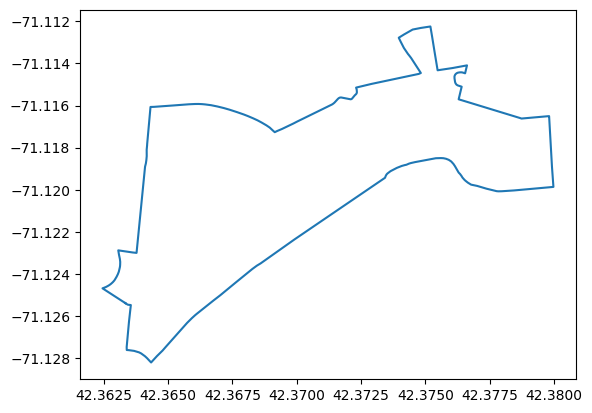

In [37]:
shape = df_shapes[df_shapes['shape_id']==48152]
lat = list(shape['shape_pt_lat'])
long = list(shape['shape_pt_lon'])
plt.plot(lat, long)

In [44]:
live_pos = open('./passio-go/public/live_files/vehiclePositions.json')
live_pos = json.load(live_pos)

In [47]:
live_pos.keys()

dict_keys(['header', 'entity'])

In [50]:
live_pos['header']

{'gtfs_realtime_version': '2.0', 'incrementality': 0, 'timestamp': 1708982484}

In [80]:
# live_pos['entity']: list of dictionarys, where each dict corresponds to a bus's current position information
live_pos['entity'][1]['vehicle']

{'vehicle': {'id': '2884', 'label': '206'},
 'position': {'latitude': 42.38051,
  'longitude': -71.1243845,
  'speed': 2.52,
  'bearing': 226},
 'current_stop_sequence': 8,
 'stop_id': '23509',
 'timestamp': 1708982480,
 'trip': {'trip_id': '670551'}}

In [57]:
'''
Given one dict:
    match 'trip_id' in trips.txt to get 'route_id' 
    match 'route_id' in routes.txt to only get routes [778, 2235, 790], [allston look, quad sec, quad express]
'''
df_trips = pd.read_csv('./passio-go/public/google_transit/trips.txt')
df_routes = pd.read_csv('./passio-go/public/google_transit/routes.txt')

In [61]:
df_routes[df_routes['route_short_name']=='AL']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
1,778,831,AL,Allston Loop,3,A50606,FFFFFF


In [63]:
df_routes[df_routes['route_short_name']=='QSEC']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
14,2235,831,QSEC,Quad SEC Direct,3,9467BD,FFFFFF


In [64]:
df_routes[df_routes['route_short_name']=='QE']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
13,790,831,QE,Quad Express,3,136D1C,FFFFFF


In [79]:
# route_id 778: AL
# route_id 2235: QSEC
# route_id 790: QE

routes_of_interest = [778, 2235, 790]
trips_per_route = {}
routes_of_interest_df = df_trips[df_trips['route_id'].apply(lambda x: x in routes_of_interest)] # 136 trips that are either AL, QSEC, or QE

for route_id in routes_of_interest:
    trips_list = list(df_trips[df_trips['route_id']==route_id]['trip_id'].apply(lambda x: int(x)))
    trips_per_route[route_id] = trips_list

with open('trips_per_route.json', 'w') as f:
    json.dump(trips_per_route, f)

In [127]:
df_trips[df_trips['trip_id']==670180]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
200,790,48152.126137,670180,NaN,NaN,NaN,23713,48166,0,0


In [142]:
df_stop_times[(df_stop_times['trip_id']==670375) & (df_stop_times['stop_id']==5045)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint
1168,670375,09:15:00,09:15:00,5045,8,NaN,NaN,NaN,1


In [145]:
trips_per_route_dict = {"778": [661197, 661198, 661199, 661200, 661201, 661203, 661204, 664485, 661205, 661206, 661207, 661208, 661210, 661211, 661212, 661213, 661214, 661215, 661216, 661217, 661218, 661219, 661220, 661221, 661223, 661224, 661225, 661226, 661227, 661228, 661229, 661309, 661316, 661317, 661318, 661319, 661320, 670445, 670446, 670447, 670450, 670612, 670613, 670614, 670615, 670616], "2235": [661310, 670460, 670461, 670503, 670504, 670505, 670506, 670507, 670508, 670509, 670510, 670511, 670512, 670531, 670532, 670533, 670534, 670535, 670536, 670537, 670539, 670540, 670541, 670542, 670543, 670544, 670545, 670546, 670547, 670548, 670549, 670550, 670551, 670552, 670553, 670554, 670555, 670556], "790": [661290, 661291, 661292, 661293, 661294, 661295, 661296, 661297, 661298, 661299, 661300, 661301, 661302, 661303, 661304, 661305, 661306, 670178, 670179, 670180, 670181, 670182, 670183, 670184, 670185, 670186, 670187, 670188, 670189, 670190, 670191, 670192, 670193, 670194, 670195, 670196, 670197, 670198, 670201, 670202, 670203, 670204, 670205, 670206, 670207, 670208, 670209, 670210, 670211, 670212, 670213, 670214]}
trips_we_care_about = []

for key, value in trips_per_route_dict.items():
    trips_we_care_about += value 

trips_we_care_about = list(set(trips_we_care_about)) # 136 trips we care about
len(trips_we_care_about)

136

In [194]:
f = open('json_dump.json')
data_ivy = json.load(f)

g = open('kento_data.txt', 'r')
data_kento = g.readlines()

In [176]:
# data[i]['entity'][j]['trip_update']['trip']['trip_id']
# only look at stop '5045' (lamont)

# to expand, make a list of all routes that 3 buses pass through...it's hard coded but at this point i'm so tired

pred_time_list = []
actual_time_list = []

for i in range(len(data_ivy)):
    # for each bus id
    for j in range(len(data_ivy[i]['entity'])):
        trip_id = int(data_ivy[i]['entity'][j]['trip_update']['trip']['trip_id'])

        # if trip is along one of the three routes
        if trip_id in trips_we_care_about:
            pred_stop_times_list = data_ivy[i]['entity'][j]['trip_update']['stop_time_update']

            for stop_dict in pred_stop_times_list:
                # stop_dict: stop_id : ###, arrival : {time: ###}
                stop_id = int(stop_dict['stop_id'])
                pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
                # rn just looking at the lamont stop
                if stop_id == 5045:
                    actual_arrival_time_military = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                    if len(actual_arrival_time_military) > 0:
                        actual_arrival_time_military = actual_arrival_time_military[0]
                        actual_arrival_time_military = time.strptime(f'2024-03-06 {actual_arrival_time_military}', '%Y-%m-%d %H:%M:%S')
                        actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

                        pred_time_list.append(pred_arrival_time)
                        actual_time_list.append(actual_arrival_time_epoch)

                        # actual_depart_time = df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['departure_time']
            
for trip_dict in data_kento:
    trip_dict = json.loads(trip_dict) # convert str to dict
    entity = trip_dict['tripUpdates']['entity']

    for j in range(len(entity)):
        trip_id = int(entity[j]['trip_update']['trip']['trip_id'])

        # if trip is along one of the three routes
        if trip_id in trips_we_care_about:
            pred_stop_times_list = entity[j]['trip_update']['stop_time_update']

            for stop_dict in pred_stop_times_list:
                # stop_dict: stop_id : ###, arrival : {time: ###}
                stop_id = int(stop_dict['stop_id'])
                pred_arrival_time = int(stop_dict['arrival']['time']) # in epoch
                # rn just looking at the lamont stop
                if stop_id == 5045:
                    actual_arrival_time_military = list(df_stop_times[(df_stop_times['trip_id']==trip_id) & (df_stop_times['stop_id']==stop_id)]['arrival_time'])
                    if len(actual_arrival_time_military) > 0:
                        actual_arrival_time_military = actual_arrival_time_military[0]
                        actual_arrival_time_military = time.strptime(f'2024-03-07 {actual_arrival_time_military}', '%Y-%m-%d %H:%M:%S')
                        actual_arrival_time_epoch = int(time.mktime(actual_arrival_time_military))

                        pred_time_list.append(pred_arrival_time)
                        actual_time_list.append(actual_arrival_time_epoch)

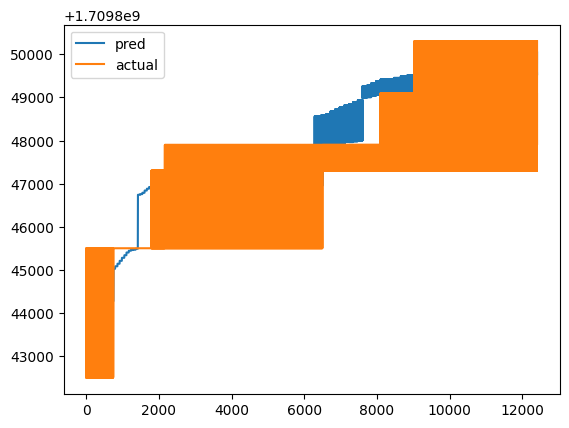

In [193]:
plt.plot(pred_time_list, label='pred')
plt.plot(actual_time_list, label='actual')
plt.legend()

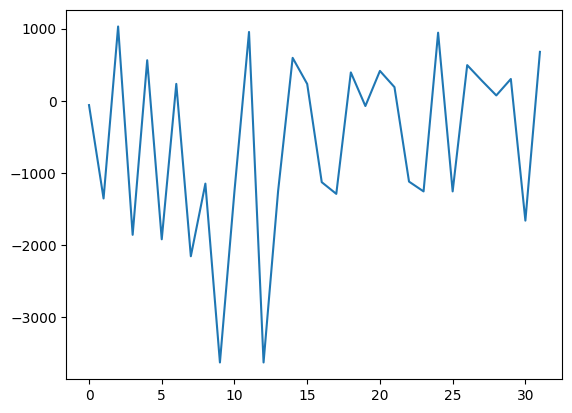

In [179]:
diff_time_list = [actual_time_list[i] - pred_time_list[i] for i in range(min(len(actual_time_list), len(pred_time_list)))]
plt.plot(diff_time_list)

In [155]:
time_tuple = time.strptime('2024-03-09 16:30:00', '%Y-%m-%d %H:%M:%S')
time_epoch = time.mktime(time_tuple)
time_epoch

1710019800.0